In [19]:
import re
import random
import pandas as pd
import hashlib

In [20]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.75) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.75) for _ in cards_to_age.index]


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [21]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure AI Search,129.659600,9.261400,14
Network Mapping,190.881329,9.089587,21
AKS,195.740629,65.246876,3
Lost in a Good Book,204.017636,10.200882,20
MS Identity Platform,584.352851,83.478979,7
Taxes,734.239966,73.423997,10
sklearn,825.574376,165.114875,5
Finance Junk,909.216335,113.652042,8
Open Source/GitHub,970.479340,42.194754,23
PEP 8,1043.870839,35.995546,29


# Histogram

40419.94


<Axes: >

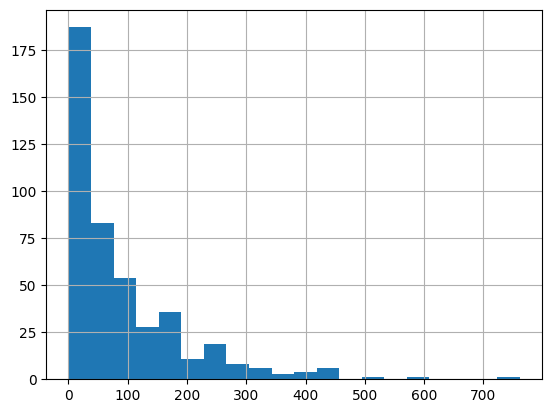

In [22]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [23]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [24]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [25]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# Focus on one header

In [26]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [27]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [28]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [29]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [30]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

## Age Sum

In [31]:
# n=4
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [32]:
n=6
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
existing_cards['age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)


Cards found: 448


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
3,Diffusers Library,Variational Inference\nA technique for approxi...,127e0fbcecea168f13d0bbc0a10a1081,-760.883326,221.654321,-760.883326,2881.506174,0.782948,0,0
4,Diffusers Library,ELBO (Evidence Lower Bound)\nA loss function t...,3c08814aea7ad722d8959f3c1c6ab2f7,-293.946899,221.654321,-760.883326,2881.506174,0.782948,1,0
5,Diffusers Library,Score Matching\nA method to train models by es...,9c74ec62220ff8a10b5742d1e20adcbd,-255.845737,221.654321,-760.883326,2881.506174,0.782948,2,0
6,Diffusers Library,Text-Guided Image-to-Image Translation: Adapt ...,02e087e5dd26cacf7bbd59b834d03a4f,-249.306725,221.654321,-760.883326,2881.506174,0.782948,3,0
7,Diffusers Library,Likelihood Estimation\nThe process of calculat...,f6ee714e6a98efeb6b1bbad8a3c80c5b,-242.776165,221.654321,-760.883326,2881.506174,0.782948,4,0
8,Diffusers Library,Stochastic Differential Equations (SDEs)\nThes...,156a34280c42128b66ec481fa994ea63,-200.309522,221.654321,-760.883326,2881.506174,0.782948,5,0
9,Search Engine Optimization,Google Analytics is a free web analytics servi...,0b8435b0770485c8097a52c881500c23,-580.034723,102.467236,-580.034723,2049.344725,0.925315,0,0
10,Search Engine Optimization,Content quality refers to the overall value an...,3c3139e4d2986495bf23c0d3e2ad49e0,-299.693409,102.467236,-580.034723,2049.344725,0.925315,1,0
11,Search Engine Optimization,Robots.txt is a text file placed in the root d...,1f385d8a36e33b814b541336c0c68d84,-260.921916,102.467236,-580.034723,2049.344725,0.925315,2,0
12,Search Engine Optimization,SEOquake is a browser extension that provides ...,d7914640266665f7eb3726d2cace41c7,-178.430723,102.467236,-580.034723,2049.344725,0.925315,3,0


## Age Mean

In [33]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)


In [34]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,count,n_fold
3,Diffusers Library,Variational Inference\nA technique for approxi...,127e0fbcecea168f13d0bbc0a10a1081,-760.883326,221.654321,-760.883326,2881.506174,0.782948,0,0
4,Diffusers Library,ELBO (Evidence Lower Bound)\nA loss function t...,3c08814aea7ad722d8959f3c1c6ab2f7,-293.946899,221.654321,-760.883326,2881.506174,0.782948,1,0
5,Diffusers Library,Score Matching\nA method to train models by es...,9c74ec62220ff8a10b5742d1e20adcbd,-255.845737,221.654321,-760.883326,2881.506174,0.782948,2,0
6,Diffusers Library,Text-Guided Image-to-Image Translation: Adapt ...,02e087e5dd26cacf7bbd59b834d03a4f,-249.306725,221.654321,-760.883326,2881.506174,0.782948,3,0
7,Diffusers Library,Likelihood Estimation\nThe process of calculat...,f6ee714e6a98efeb6b1bbad8a3c80c5b,-242.776165,221.654321,-760.883326,2881.506174,0.782948,4,0
8,Diffusers Library,Stochastic Differential Equations (SDEs)\nThes...,156a34280c42128b66ec481fa994ea63,-200.309522,221.654321,-760.883326,2881.506174,0.782948,5,0
9,Search Engine Optimization,Google Analytics is a free web analytics servi...,0b8435b0770485c8097a52c881500c23,-580.034723,102.467236,-580.034723,2049.344725,0.925315,0,0
10,Search Engine Optimization,Content quality refers to the overall value an...,3c3139e4d2986495bf23c0d3e2ad49e0,-299.693409,102.467236,-580.034723,2049.344725,0.925315,1,0
11,Search Engine Optimization,Robots.txt is a text file placed in the root d...,1f385d8a36e33b814b541336c0c68d84,-260.921916,102.467236,-580.034723,2049.344725,0.925315,2,0
12,Search Engine Optimization,SEOquake is a browser extension that provides ...,d7914640266665f7eb3726d2cace41c7,-178.430723,102.467236,-580.034723,2049.344725,0.925315,3,0


In [35]:
existing_cards.head(10)['age'].sum()

-3322.1491439426204